# Lab: TP 2

In [ ]:
import numpy as np
import scipy.linalg as linalg
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Notebook settings
from IPython.core.display import HTML

HTML("""
<style>
.container {
    width: 60% !important;
}
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


# 1. The data

In [ ]:
def load_data(seed=1, n_train=100):
    data = np.genfromtxt('wine_data.csv', delimiter=',')
    X, y = data[:,1:], data[:,0]
    return X,y
    
def train_test_split(X, y, test_size, shuffle=True, random_state=123):
    assert X.shape[0] == y.shape[0]
    m = X.shape[0]
    
    if shuffle:
        np.random.seed(random_state)
        perm = np.random.permutation(m)
        
    m_test = int(np.ceil(m*test_size))
    X_test = X[perm[-m_test:],:]
    X_train = X[perm[:-m_test],:]
    y_test = y[perm[-m_test:]]
    y_train = y[perm[:-m_test]]
    
    return X_train, X_test, y_train, y_test 
    
X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
def plot_decision_regions(ax, X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min,x1_max = X[:,0].min()-0.5,X[:,0].max()+0.5
    x2_min,x2_max = X[:,1].min()-0.5,X[:,1].max()+0.5

    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                          np.arange(x2_min,x2_max,resolution))
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                   y=X[y == cl, 1],
                   alpha=0.6,
                   c=cmap(idx),
                   edgecolor='black',
                   marker=markers[idx])

def plot_2_axes(ax, X, y, centroids=None):
    colors = ['r','g','b','gray', 'cyan']
    markers = ['v','s','o', '^', 'X']
    
    for cl, c, m in zip(np.unique(y), colors, markers):
        ax.scatter(X[y==cl,0],
                    X[y==cl,1],
                    color=c,marker=m,label=cl, alpha=0.6)
        
    if centroids is not None:
        for cl, c, m in zip(np.unique(y), colors, markers):
            ax.scatter(centroids[cl][0], centroids[cl][1], edgecolor="black", 
                        linewidth=3, color=c, marker=m, s=200)

## 2. What is Fisher discrimant analysis

Let us denote $x_{1:n}, y_{1:n} \sim X, Y$ i.i.d observations of $X \in \mathbb{R}^p, Y \in \{1,\ldots, k\}$.

LDA is closely related to PCA in the sense that both method try to find linear combinations of the covariates $X_1, \ldots, X_p$ that "best" explain the data. 


### PCA objective


For PCA, "best" means finding the sets of linear combinations of the $X_1,\ldots,X_p$ that results in the linear subspace that **maximizes the variance** of the projected data among all subspaces of a given dimension i.e

\begin{equation}
   H_k^* = \underset{H_k \subset \mathbb{R}^p, \mathrm{dim} (H_k)=k}{arg max}\frac{1}{n} \sum_{i=1}^n \|p_{H_k}(x_i)\|^2
\end{equation}

In short, assuming the matrix $X$ is centered (without loss of generality), the subspace $H_k^*$ is obtained by computing the **eigen decomposition of the covariance matrix $\frac{1}{n}X^\top X$**. 

More specifically, the optiomal subspace is $H_k^* = \mathrm{span}\{v_1, \ldots, v_k\}$ with $v_1, \ldots, v_k$ k eigenvectors from the eigenspaces with the $k$ highest eigenvalues $\lambda_1 \geq \ldots \geq \lambda_k$.

Choosing the $v_1, \ldots, v_k$ to be orthonormal, the projection matrix is given by
\begin{equation}
    W_k = \begin{bmatrix} v_1 & v_2 & \cdots & v_k \end{bmatrix}
\end{equation}

###  Fisher LDA objective


For Fisher LDA, "best" means finding the sets of linear combinations of the $X_1, \ldots, X_p$ that **maximizes the "separability"** of the classes.

#### Fisher LDA for 2 classes

For 2 classes, we seek a linear combination $w_1, \ldots, w_p$ of the $X_1, \ldots, X_p$ that linearly separates the classes $1$ and $2$. 

Classification is
\begin{equation}
\begin{cases}
    1 & \text{if $w^\top X \geq t$} \\
    2 & \text{if $w^\top X < t$}
\end{cases}
\end{equation}

Let us denote
1. $n_1, n_2$ number of observations in classes 1 and 2. $n_1+n_2=n$
2. $\displaystyle m_1 = \frac{1}{n_1}\sum_{i | y_i = 1} x_i, \qquad  m_2 = \frac{1}{n_2}\sum_{i | y_i = 2} x_i$

The separation is "good" if 
1. $w^\top m_1 - w^\top m_2$ is large (**between-class**) 
2. $s_1^2 = \displaystyle \sum_{i | y_i = 1} (w^\top x_i - w^\top m_1)^2$ and $s_2^2 = \displaystyle \sum_{i | y_i = 2} (w^\top x_i - w^\top m_2)^2$ are small (**within-class**).

The Fisher objective function is
\begin{equation}
    w^* = \underset{w}{arg max} \; J(w) \quad \text{with} \quad J(w) = \frac{(w^\top m_1-w^\top m_2)^2}{s_1^2 + s_2^2}
\end{equation}

which can be rewritten
\begin{equation}
    J(w) = \frac{w^\top S_B w}{w^\top S_W w}
\end{equation}
with
\begin{equation}
    \begin{cases}
        S_B  = (m_1-m_2)(m_1-m_2)^\top & \text{between-class covariance} \\
        \displaystyle S_W  = \sum_{i | y_i = 1} (x_i - m_1)(x_i - m_1)^\top + \sum_{i | y_i = 2} (x_i - m_2)(x_i - m_2)^\top & \text{within-class covariance}
    \end{cases}
\end{equation}

##### Fitting

Solving $w$ for $\nabla J(w) = 0$ leads to
\begin{equation}
    (w^\top S_B w) S_W w = (w^\top S_W w) S_B w
\end{equation}

The scale of $w$ being arbitrary, an optimal $w$ satisfies
\begin{equation}
    S_B w = \lambda S_W w
\end{equation}

If $S_W$ is invertible, an optimal $w$ satisfies
\begin{equation}
    S_W^{-1} S_B w = \lambda w
\end{equation}    
i.e **$w$ is an eigenvector of $S_W^{-1} S_B$.**

#### Fisher LDA > 2 classes

The same Fisher objective function is maximized

\begin{equation}
    W^* = \underset{W \in \mathbb{R}^{p \times k} }{arg max} \; J(W) \quad \text{with} \quad J(W) = \frac{|W^\top S_B W|}{|W^\top S_W W|}
\end{equation}
with
\begin{equation}
    \begin{cases}
        \displaystyle S_B  = \sum_{q=1}^k n_q (m_q-m)(m_q-m)^\top & \text{between-class covariance} \\
        \displaystyle S_W  = \sum_{q=1}^k \sum_{i | y_i = q} (x_i - m_q)(x_i - m_q)^\top & \text{within-class covariance}
    \end{cases}
\end{equation}

It can be shown that the optimal matrix of linear combinations, $W$, is given by

\begin{equation}
    W_k = \begin{bmatrix} v_1 & v_2 & \cdots & v_{k-1} \end{bmatrix}
\end{equation}

with $v_1, \ldots, v_{k-1}$ the $k-1$ orthonormal eigenvectors from the eigenspaces with the $k-1$ highest eigenvalues $|\lambda_1| \geq \ldots \geq |\lambda_{k-1}|$ of the $S_W^{-1}S_B$ matrix.

## 3. Implementation

In [ ]:
Z = np.array([1,2,3])

In [ ]:
Z.shape

(3,)

In [ ]:
Z.reshape(-1,1).shape

(3, 1)

In [ ]:
Z.reshape(1,-1).shape

(1, 3)

In [ ]:
def class_means(X, y):
    mus = {} 
    for cl in np.unique(y):
        mus[cl] = np.mean(X[y==cl], axis=0)
    return mus

def between_class_cov(X, y):
    S_B = np.zeros((X.shape[1], X.shape[1]))
    mus = class_means(X,y)
    mu = np.mean(X, axis=0)
    
    for cl, mu_cl in mus.items():
        n_cl = sum(y==cl)
        S_B_cl = (mu_cl - mu).reshape(-1, 1).dot((mu_cl-mu).reshape(1,-1))
        S_B += n_cl * S_B_cl

    return S_B

def within_class_cov(X, y):
    S_W = np.zeros((X.shape[1], X.shape[1]))
    mus = class_means(X, y)
    
    for cl, mu_cl in mus.items():
        n_cl = sum(y==cl)
        S_W_cl = np.cov(X[y==cl].T, bias=True)
        S_W += n_cl * S_W_cl

    return S_W
    
def fit_LDA(X, y):
    """
    Train a LDA classifier
    X: data
    y: labels
    """  
    # Covariance matrices
    S_B = between_class_cov(X,y)
    S_W = within_class_cov(X,y)
    
    # Build W from eigen decomposition of V = S_W^{-1} S_B
    V = linalg.inv(S_W).dot(S_B)
    eig_vals, eig_vecs = linalg.eig(V)
    
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda t: t[0], reverse=True)
    
    k = len(np.unique(y))
    W = np.hstack([eig_pairs[l][1].real.reshape(-1,1) for l in range(k-1)])
    
    # Project on W
    X_lda = X.dot(W)
    mus = class_means(X,y)
    mus_lda = {}
    for cl, mu_cl in mus.items():
        mus_lda[cl] = W.T.dot(mu_cl)
        
    return W, mus_lda, X_lda

### 3.1 Fit LDA

In [ ]:
W, mus_lda, X_train_lda = fit_LDA(X_train, y_train)

### 3.2 Plot fit

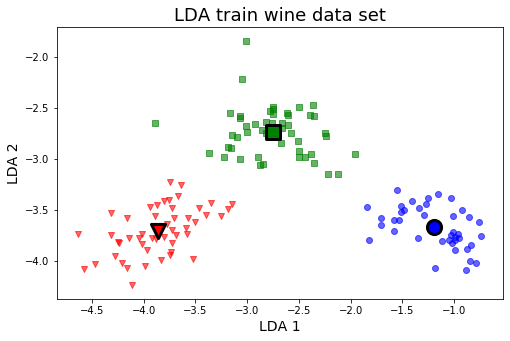

In [ ]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

plot_2_axes(ax, X_train_lda, y_train, mus_lda)
ax.set_xlabel("LDA 1", fontsize=14)
ax.set_ylabel("LDA 2", fontsize=14)
ax.set_title("LDA train wine data set", fontsize=18, fontweight="medium")
ax.set_title("LDA train wine data set", fontsize=18, fontweight="medium")

plt.show()

### 3.3 Predict

In [ ]:
def predict(X, W, mus_lda):
    """
    Apply the trained LDA classifier (W, mus_lda) on the test data
    X: test data
    W: projection matrix
    mus_lda: class means projections
    """

    # Project test data onto the LDA space defined by W
    X_lda = X.dot(W)
    
    # Pairwise distances
    classes = list(mus_lda.keys())
    Mus_lda = np.vstack([mus_lda[cl].reshape(1,-1) for cl in classes])
    D = cdist(X_lda, Mus_lda, metric="euclidean")
    
    pred = np.argmin(D, axis=1)
    pred = np.array([classes[pred_i] for pred_i in pred]) 

    return pred

In [ ]:
def compute_accuracy(y, pred):
    return np.mean(y==pred)

In [ ]:
pred_train = predict(X_train, W, mus_lda)
pred_test = predict(X_test, W, mus_lda)

acc_train = compute_accuracy(y_train, pred_train)
acc_test = compute_accuracy(y_test, pred_test)

print('Train Accuracy: {:.2f} %'.format(acc_train * 100.0))
print('Test Accuracy: {:.2f} %'.format(acc_test * 100.0))

Train Accuracy: 99.30 %
Test Accuracy: 97.22 %


## 4. Object

In [ ]:
class LDA(object):
    """
    Class for fitting Fisher discriminant analysis.
    """
    def __init__(self):
        self.W = None
        self.mus = None
        self.mus_lda = None
        
    def fit(self, X, y):
        self.mus = self._class_means(X, y)
        
         # Covariance matrices
        S_B = self._between_class_cov(X,y)
        S_W = self._within_class_cov(X,y)

        # Build W from eigen decomposition of V = S_W^{-1} S_B
        V = linalg.inv(S_W).dot(S_B)
        eig_vals,eig_vecs = linalg.eig(V)

        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda k:k[0], reverse=True)

        k = len(np.unique(y))
        self.W = np.hstack([eig_pairs[l][1].reshape(-1,1).real for l in range(k-1)])

        # Project on W
        self.mus_lda = {}
        for cl, mu_cl in self.mus.items():
            self.mus_lda[cl] = W.T.dot(mu_cl)

        X_lda = X.dot(W)
        
        return self
    
    def predict(self, X):
        # Project test data onto the LDA space defined by W
        X_lda = X.dot(self.W)

        classes = list(mus_lda.keys())
        Mus_lda = np.vstack([self.mus_lda[cl].reshape(1,-1) for cl in classes])
        D = cdist(X_lda, Mus_lda)

        pred = np.argmin(D, axis=1)
        pred = np.array([classes[pred_i] for pred_i in pred])
        return pred
        
    # internal
    def _class_means(self, X, y):
        mus = {}
        for cl in np.unique(y):
            mus[cl] = np.mean(X[y==cl], axis=0)
        return mus

    def _between_class_cov(self, X, y):
        mu = np.mean(X, axis=0)
        S_B = np.zeros((X.shape[1], X.shape[1]))

        for cl, mu_cl in self.mus.items():
            n_cl = sum(y==cl)
            S_B_cl = (mu_cl - mu).reshape(-1,1).dot((mu_cl-mu).reshape(1,-1))
            S_B += n_cl * S_B_cl

        return S_B

    def _within_class_cov(self, X, y):
        mu = np.mean(X, axis=0)
        S_W = np.zeros((X.shape[1], X.shape[1]))

        for cl, mu_cl in self.mus.items():
            n_cl = sum(y==cl)
            S_W_cl = np.cov(X[y==cl].T)
            S_W += n_cl * S_W_cl

        return S_W

In [ ]:
lda = LDA()
lda = lda.fit(X_train,y_train)
acc_train = compute_accuracy(y_train, lda.predict(X_train))
acc_test = compute_accuracy(y_test, lda.predict(X_test))

print('Train Accuracy: {:.2f} %'.format(acc_train * 100.0))
print('Test Accuracy: {:.2f} %'.format(acc_test * 100.0))

Train Accuracy: 99.30 %
Test Accuracy: 97.22 %
